In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import shap

c:\Users\ms\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_df = pd.read_csv("data/test.csv",sep=";")
test_df['timestamp'] = pd.to_datetime(test_df['date'], format='%d.%m.%Y')
test_df = test_df.drop(columns=['date', 'row_id'])

In [3]:
test_df["item_id"].nunique()
item_ids_test = test_df["item_id"].unique()

In [4]:
item_store_counts = test_df.groupby('item_id')['store_id'].nunique()

In [5]:
items_in_multiple_stores = item_store_counts[item_store_counts == 4]
print(len(items_in_multiple_stores))

1403


What we can understand from test_csv :

- There are 4 stores and a same item can be found in multiple stores
- Out of 13636 items only 1403 items are found in all the stores
- Our GOAL will be to predict the quantity of the item_id sold on that day on that store

In [6]:
offline_sales_df = pd.read_csv("data/sales.csv",sep=",")
offline_sales_df['timestamp'] = pd.to_datetime(offline_sales_df['date'])
offline_sales_df = offline_sales_df.drop(columns=['date', 'Unnamed: 0'])

In [7]:
online_sales_df = pd.read_csv("data/online.csv",sep=",")
online_sales_df['timestamp'] = pd.to_datetime(online_sales_df['date'])
online_sales_df = online_sales_df.drop(columns=['date', 'Unnamed: 0'])

In [8]:
#first lets us check teh items which available online but not offline 

online_items = set(online_sales_df["item_id"].unique())
offline_items = set(offline_sales_df["item_id"].unique())


unique_online_items =online_items - offline_items
unique_offline_items = offline_items - online_items

print("Unique to online", len(unique_online_items))
print("Unique to offline", len(unique_offline_items))

Unique to online 141
Unique to offline 9918


In [9]:
offline_sales_df['source'] = 'offline'
online_sales_df['source'] = 'online'

combined_sales_df = pd.concat([offline_sales_df, online_sales_df], ignore_index=True)

In [10]:
combined_sales_df.head()

,item_id,quantity,price_base,sum_total,store_id,timestamp,source
0,293375605257,1.000,47.86,47.86,1,2023-08-04,offline
1,a66fdf2c0ae7,3.000,49.60,148.80,1,2023-08-04,offline
2,daa46ef49b7a,0.822,379.00,311.54,1,2023-08-04,offline
3,a3b49c1bf758,1.000,129.00,129.00,1,2023-08-04,offline
4,ab611c5cef62,7.000,79.90,559.30,1,2023-08-04,offline


In [11]:
print(combined_sales_df.shape)

(8556097, 7)


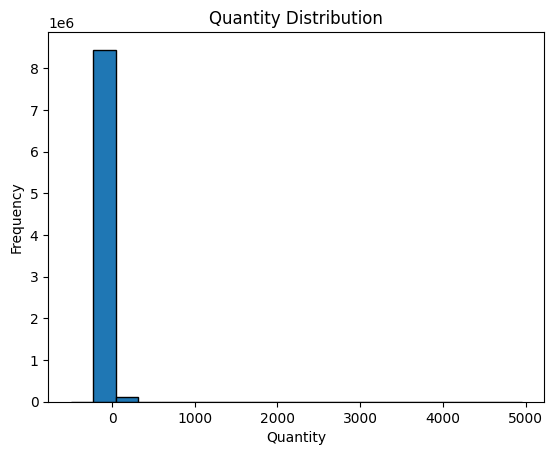

In [12]:
import matplotlib.pyplot as plt


plt.hist(combined_sales_df['quantity'], bins=20, edgecolor='black')


plt.title('Quantity Distribution')
plt.xlabel('Quantity')
plt.ylabel('Frequency')

plt.show()

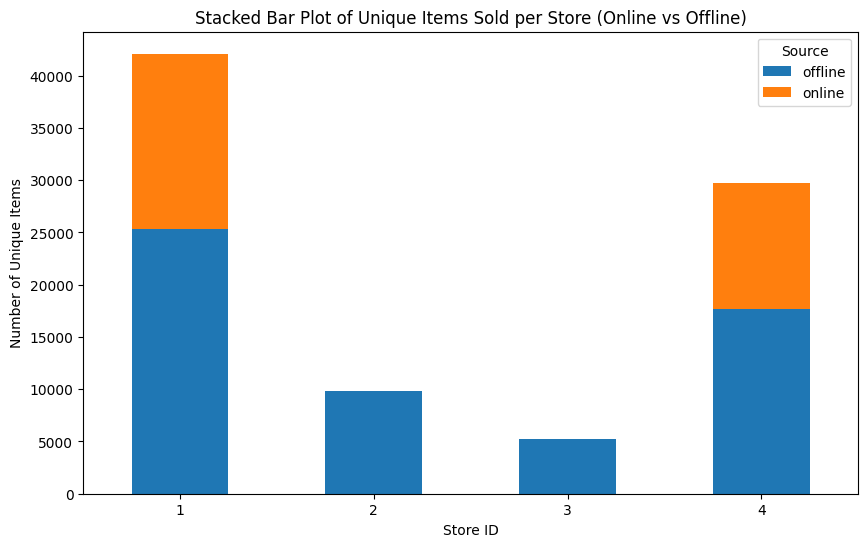

In [13]:
grouped_data = combined_sales_df.groupby(['store_id', 'source'])['item_id'].nunique().reset_index()
pivot_data = grouped_data.pivot(index='store_id', columns='source', values='item_id').fillna(0)


pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Stacked Bar Plot of Unique Items Sold per Store (Online vs Offline)')
plt.xlabel('Store ID')
plt.ylabel('Number of Unique Items')
plt.legend(title='Source')
plt.xticks(rotation=0)

plt.show()

In [14]:
### Averaging baseline

# The idea of this is submit a baseline to check if we really need ML and what will happpen if we try to approach the solution using non ML ways.

In [15]:
combined_sales_df['month'] = combined_sales_df['timestamp'].dt.month
test_df['month'] = test_df['timestamp'].dt.month

In [16]:
monthly_averages = (
    combined_sales_df
    .groupby(['item_id', 'store_id', 'month'], as_index=False)
    .agg(avg_quantity=('quantity', 'mean'))
)

In [17]:
temp_df = pd.merge(test_df, monthly_averages, on=['item_id', 'store_id', 'month'], how='left')
fallback_item_store = (
    combined_sales_df
    .groupby(['item_id', 'store_id'], as_index=False)
    .agg(item_store_avg=('quantity', 'mean'))
)
temp_df  = pd.merge(temp_df, fallback_item_store, on=['item_id', 'store_id'], how='left')
temp_df['avg_quantity'] = np.where(temp_df['avg_quantity'].isna(), temp_df['item_store_avg'], temp_df['avg_quantity'])

global_avg = combined_sales_df['quantity'].mean()
temp_df['avg_quantity'].fillna(global_avg, inplace=True)

C:\Users\ms\AppData\Local\Temp\ipykernel_10168\1367022231.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp_df['avg_quantity'].fillna(global_avg, inplace=True)


In [18]:
temp_df.head()

,item_id,store_id,timestamp,month,avg_quantity,item_store_avg
0,c578da8e8841,1,2024-09-27,9,6.729412,6.452
1,c578da8e8841,1,2024-09-28,9,6.729412,6.452
2,c578da8e8841,1,2024-09-29,9,6.729412,6.452
3,c578da8e8841,1,2024-09-30,9,6.729412,6.452
4,c578da8e8841,1,2024-10-01,10,5.915254,6.452


In [19]:
combined_sales_df.describe()

,quantity,price_base,sum_total,store_id,timestamp,month
count,8.556097e+06,8.556097e+06,8.556097e+06,8.556097e+06,8556097,8.556097e+06
mean,5.189724e+00,1.999951e+02,6.909861e+02,1.991254e+00,2023-11-05 10:10:48.412566272,6.363315e+00
min,-5.000000e+02,-2.167667e+04,-2.041080e+04,1.000000e+00,2022-08-28 00:00:00,1.000000e+00
25%,1.000000e+00,5.990000e+01,1.108100e+02,1.000000e+00,2023-04-29 00:00:00,3.000000e+00
50%,2.000000e+00,1.049000e+02,2.299000e+02,1.000000e+00,2023-12-25 00:00:00,6.000000e+00
75%,4.000000e+00,1.999000e+02,5.397000e+02,3.000000e+00,2024-05-13 00:00:00,9.000000e+00
max,4.952000e+03,2.899990e+04,6.865242e+05,4.000000e+00,2024-09-26 00:00:00,1.200000e+01
std,2.560741e+01,3.248473e+02,4.470248e+03,1.218316e+00,NaN,3.347818e+00


In [20]:
combined_sales_df["day_of_week"] = combined_sales_df["timestamp"].dt.dayofweek
combined_sales_df['year'] = combined_sales_df["timestamp"].dt.year
combined_sales_df['day_of_month'] = combined_sales_df["timestamp"].dt.day

test_df["day_of_week"] = test_df["timestamp"].dt.dayofweek
test_df['year'] = test_df["timestamp"].dt.year
test_df['day_of_month'] = test_df["timestamp"].dt.day

In [21]:
combined_sales_df.head()

,item_id,quantity,price_base,sum_total,store_id,timestamp,source,month,day_of_week,year,day_of_month
0,293375605257,1.000,47.86,47.86,1,2023-08-04,offline,8,4,2023,4
1,a66fdf2c0ae7,3.000,49.60,148.80,1,2023-08-04,offline,8,4,2023,4
2,daa46ef49b7a,0.822,379.00,311.54,1,2023-08-04,offline,8,4,2023,4
3,a3b49c1bf758,1.000,129.00,129.00,1,2023-08-04,offline,8,4,2023,4
4,ab611c5cef62,7.000,79.90,559.30,1,2023-08-04,offline,8,4,2023,4


In [22]:
# Now that we have added all the columns 

# our main target column is the quantity column
# We have another aspect to consider before building the ML model  

### How do we deal with the High Cardinality of the item_id?
##### https://towardsdatascience.com/4-ways-to-encode-categorical-features-with-high-cardinality-1bc6d8fd7b13

#### From the above article we have 4 options:
#####(1) Target encoding
#####(2) Count encoding
#####(3) Feature hashing
#####(4) Embedding

In [23]:
# For the baseline lets work with 1st and the 2nd method
# Since we are using Random forests, Lets go with Target encoding as it works best with the tree based methods

In [24]:
# Since in traget encoding there is danger of target leakage, let us use K fold validation.
# But we have to make sure that first the item ids in test set exist in the train set too 

In [25]:
all_items = set(combined_sales_df["item_id"].to_list())
test_items = set(test_df["item_id"].to_list())


missing_items = test_items - all_items
print(len(missing_items))

missing_indices_from_data = test_df[test_df["item_id"].isin(missing_items)].index

test_df_new = test_df.drop(index=missing_indices_from_data)

test_df_new = test_df_new.reset_index(drop=True)

print(test_df.shape)
print(test_df_new.shape)

valid_indices = test_df.index.difference(missing_indices_from_data)


182
(883680, 7)
(875040, 7)


In [26]:
#########################
#CHATGPT
#########################

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

def target_encode(train_series, target, test_series, n_splits=5, random_state=42):
    """
    Perform target encoding on a categorical feature.

    Parameters:
    - train_series: pd.Series, categorical feature from training data
    - target: pd.Series, target variable from training data
    - test_series: pd.Series, categorical feature from test data
    - n_splits: int, number of K-Fold splits
    - random_state: int, random seed

    Returns:
    - encoded_train: pd.Series, target-encoded training feature
    - encoded_test: pd.Series, target-encoded test feature
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    encoded_train = pd.Series(np.nan, index=train_series.index)

    for train_idx, val_idx in kf.split(train_series):
        means = target.iloc[train_idx].groupby(train_series.iloc[train_idx]).mean()
        encoded_train.iloc[val_idx] = train_series.iloc[val_idx].map(means)
    
    # Global mean to fill missing values
    global_mean = target.mean()
    encoded_train.fillna(global_mean, inplace=True)
    
    # Compute means from entire training data for test set
    means_full = target.groupby(train_series).mean()
    encoded_test = test_series.map(means_full)
    encoded_test.fillna(global_mean, inplace=True)
    
    return encoded_train, encoded_test


In [27]:
combined_sales_df['item_id_enc'],test_df_new["item_id_enc"] = target_encode(combined_sales_df['item_id'], combined_sales_df['quantity'],test_df_new["item_id"])

In [28]:
exclude_cols = ['timestamp', 'item_id', 'sum_total', 'source','quantity','price_base']
features = [col for col in combined_sales_df.columns if col not in exclude_cols]

print("Selected Features:", features)
target = 'quantity'

Selected Features: ['store_id', 'month', 'day_of_week', 'year', 'day_of_month', 'item_id_enc']


In [29]:

train_data = combined_sales_df[combined_sales_df['timestamp'] < '2024-06-01']  
valid_data = combined_sales_df[combined_sales_df['timestamp'] >= '2024-06-01']


In [30]:
X_train = train_data[features]
y_train = train_data[target]
X_valid = valid_data[features]
y_valid = valid_data[target]
X_test = test_df_new[features]

In [31]:
rf_model = RandomForestRegressor(
    n_estimators=30,       
    max_depth=None,         
    min_samples_split=2,    
    min_samples_leaf=1,     
    random_state=42,        
    verbose =2,
    n_jobs=5              
)

rf_model.fit(X_train, y_train)



[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 30building tree 2 of 30
building tree 3 of 30

building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:  6.7min finished


RandomForestRegressor(n_estimators=30, n_jobs=5, random_state=42, verbose=2)

In [32]:
preds_valid = rf_model.predict(X_valid)

rmse = root_mean_squared_error(y_valid, preds_valid)
print(f'Validation RMSE: {rmse}')


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:   17.3s finished


Validation RMSE: 14.632038472644728


In [33]:
preds_test = rf_model.predict(X_test)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    4.0s finished


In [34]:

all_indices = np.arange(test_df.shape[0]) 
valid_indices = valid_indices
missing_list_indices = missing_indices_from_data

# Example predictions corresponding to valid_indices in the same order
predictions =preds_test

# We'll create a map from valid index to prediction
pred_map = dict(zip(valid_indices, predictions))

# Now we construct the final quantities list.
final_quantities = []
for i in all_indices:
    if i in pred_map:
        final_quantities.append(pred_map[i])
    else:
        # i is in missing_list_indices, so we put 0
        final_quantities.append(0)

# Create a DataFrame for the final submission
submission_df= pd.DataFrame({
    'row_id': all_indices,
    'quantity': final_quantities
})


In [35]:
submission_df.to_csv('submission.csv', index=False)


In [36]:
#### Catboost

In [37]:
exclude_cols = ['timestamp', 'sum_total', 'source','quantity','price_base','item_id_enc']
features = [col for col in combined_sales_df.columns if col not in exclude_cols]

print("Selected Features:", features)
target = 'quantity'

Selected Features: ['item_id', 'store_id', 'month', 'day_of_week', 'year', 'day_of_month']


In [38]:

train_data = combined_sales_df[combined_sales_df['timestamp'] < '2024-06-01']  
valid_data = combined_sales_df[combined_sales_df['timestamp'] >= '2024-06-01']


In [39]:
X_train = train_data[features]
y_train = train_data[target]
X_valid = valid_data[features]
y_valid = valid_data[target]
X_test = test_df_new[features]

In [40]:
X_train

,item_id,store_id,month,day_of_week,year,day_of_month
0,293375605257,1,8,4,2023,4
1,a66fdf2c0ae7,1,8,4,2023,4
2,daa46ef49b7a,1,8,4,2023,4
3,a3b49c1bf758,1,8,4,2023,4
4,ab611c5cef62,1,8,4,2023,4
...,...,...,...,...,...,...
8448367,fb4c6511597e,4,5,4,2024,31
8448368,3a5b578fa513,4,5,4,2024,31
8448369,899328e2a815,4,5,4,2024,31
8448370,cea5aa10f240,4,5,4,2024,31


In [41]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=['item_id','store_id']
)


In [42]:
model = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.1,
    depth=10,
    task_type="GPU",
    one_hot_max_size=10,
    devices='0',
    loss_function='RMSE',cat_features=['item_id','store_id'],
    verbose=50)

In [43]:
model.fit(train_pool)

0:	learn: 24.2323288	total: 499ms	remaining: 33m 14s
50:	learn: 16.1300753	total: 12.5s	remaining: 16m 10s
100:	learn: 13.7178383	total: 23.8s	remaining: 15m 17s
150:	learn: 12.9206116	total: 35.4s	remaining: 15m 2s
200:	learn: 12.5076308	total: 47.4s	remaining: 14m 55s
250:	learn: 12.2056823	total: 59.3s	remaining: 14m 45s
300:	learn: 11.9554681	total: 1m 11s	remaining: 14m 39s
350:	learn: 11.7843378	total: 1m 24s	remaining: 14m 37s
400:	learn: 11.6282945	total: 1m 36s	remaining: 14m 29s
450:	learn: 11.4713781	total: 1m 49s	remaining: 14m 24s
500:	learn: 11.3813107	total: 2m 3s	remaining: 14m 21s
550:	learn: 11.2853025	total: 2m 16s	remaining: 14m 17s
600:	learn: 11.1927483	total: 2m 29s	remaining: 14m 5s
650:	learn: 11.1215714	total: 2m 43s	remaining: 14m
700:	learn: 11.0508149	total: 2m 56s	remaining: 13m 48s
750:	learn: 10.9864903	total: 3m 8s	remaining: 13m 37s
800:	learn: 10.9171596	total: 3m 22s	remaining: 13m 27s
850:	learn: 10.8520172	total: 3m 35s	remaining: 13m 16s
900:	lear

In [ ]:
preds_valid = model.predict(X_valid)

rmse = root_mean_squared_error(y_valid, preds_valid)
print(f'Validation RMSE: {rmse}')

In [ ]:

all_indices = np.arange(test_df.shape[0]) 
valid_indices = valid_indices
missing_list_indices = missing_indices_from_data

# Example predictions corresponding to valid_indices in the same order
predictions =preds_test

# We'll create a map from valid index to prediction
pred_map = dict(zip(valid_indices, predictions))

# Now we construct the final quantities list.
final_quantities = []
for i in all_indices:
    if i in pred_map:
        final_quantities.append(pred_map[i])
    else:
        # i is in missing_list_indices, so we put 0
        final_quantities.append(0)

# Create a DataFrame for the final submission
submission_df= pd.DataFrame({
    'row_id': all_indices,
    'quantity': final_quantities
})


In [ ]:
submission_df.to_csv('submission2.csv', index=False)